In [1]:
#plot sussed before and after storm surge(for all surges) 
#for different canopy heights
import numpy as np
from netCDF4 import Dataset, num2date
import matplotlib.pyplot as plt
import cftime
import matplotlib.units as munits
from matplotlib.dates import ConciseDateConverter
munits.registry[cftime.DatetimeGregorian] = ConciseDateConverter()
from matplotlib.gridspec import GridSpec
import sys
sys.path.insert(0, '/home/g/g260204/tools/python_skripts/SchismUtils/')
from schism_utils import sort_files, read_data, find_hwlw
import h5py
import pandas as pd
from datetime import datetime,timedelta


In [2]:
surges= [(2010,315),(2013,30),(2013,338),(2015,10),(2015,317),(2015,333)]#year,day
simpat = '/work/gg0877/g260204/sim_data/SR5yr/'
rsgname = 'srm036_'
nsgname = 'srm020_'
ssgname = 'srm035_'
plotpat = '/work/gg0877/g260204/sim_data/SR5yr/plots/plots/srm203536/'

mthw = (589-499)/100

In [3]:
#seagrass meadow polygons patchsav.prop
patchpat = '/work/gg0877/g260204/SR5yr/srm024_2010/patchsav.prop'
patchsav = np.genfromtxt(patchpat,delimiter=" ",dtype=np.int32)
tri = Dataset(simpat+rsgname+str(surges[0][0])+'/outputs/schout_1.nc').variables['SCHISM_hgrid_face_nodes'][:,:3]-1
face_sav = np.squeeze(np.where(patchsav[:,1]==1))

##this one first to remove cells where hcan mean is 0!
#ncpat = '/work/gg0877/g260204/sim_data/SR5yr/'+ rsgname + '/outputs'
#files_sorted = sort_files(ncpat)
#hcan  = read_data('ICM_hcansav',files_sorted,ntime=range(0,1))
#hcan[:,patchsav[:,1]==0]=np.nan
#hcan_0 = np.mean(hcan,0)
#face_sav = np.squeeze(np.where(hcan_0>0))

Loading files (srm036_2010, SED_eroflx): 100%|██████████| 3/3 [00:00<00:00,  5.22it/s]
/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:222: UserWarning: Warning: converting a masked element to nan.
  return a.dtype.type(a / b)


0.11796113123837648


Loading files (srm036_2013, SED_eroflx): 100%|██████████| 3/3 [00:00<00:00, 13.48it/s]


0.0004983356591940535


Loading files (srm036_2013, SED_eroflx): 100%|██████████| 3/3 [00:00<00:00, 28.42it/s]


0.06260146676375813


Loading files (srm036_2015, SED_eroflx): 100%|██████████| 3/3 [00:00<00:00, 12.37it/s]


0.010598200462791044


Loading files (srm036_2015, SED_eroflx): 100%|██████████| 3/3 [00:00<00:00, 26.27it/s]


0.32971500709463686


Loading files (srm036_2015, SED_eroflx): 100%|██████████| 3/3 [00:00<00:00, 23.25it/s]


0.15709500243467028


Loading files (srm020_2015, SED_eroflx): 100%|██████████| 3/3 [00:00<00:00, 12.08it/s]


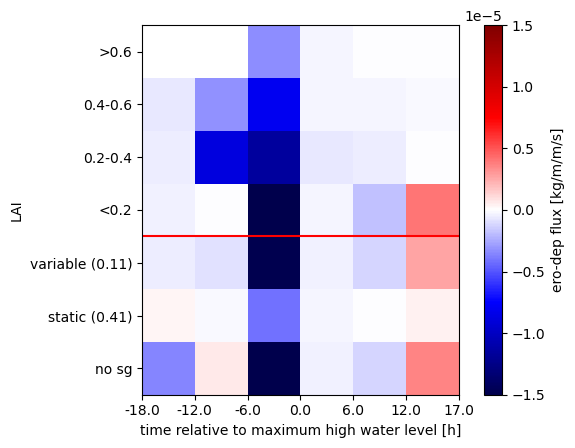

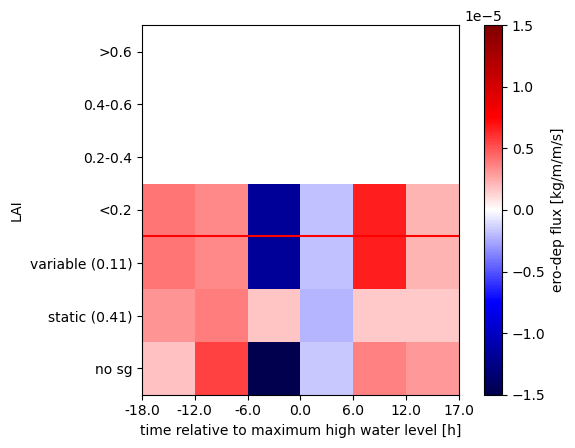

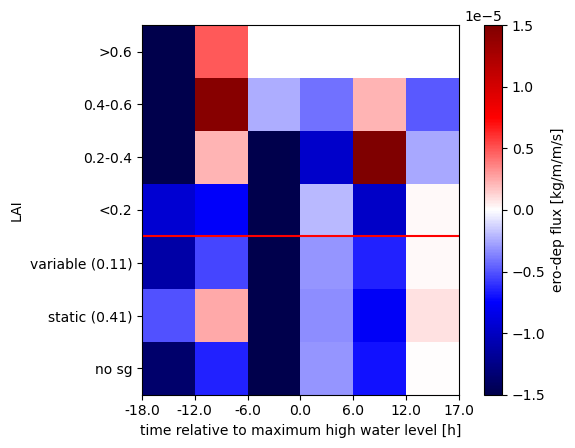

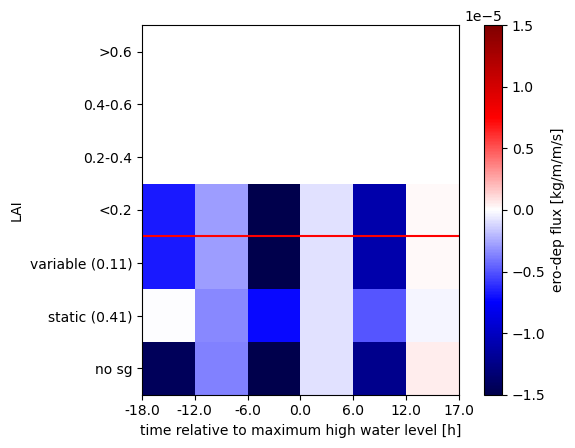

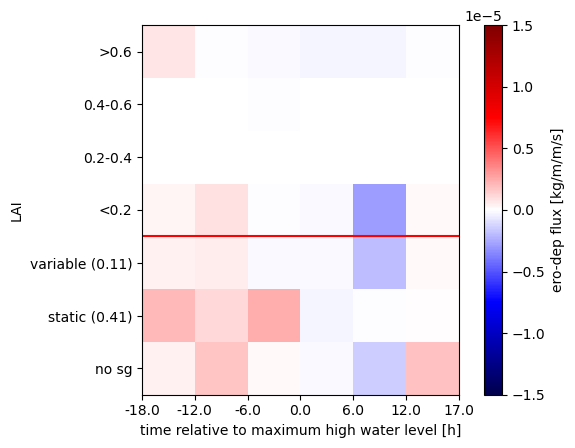

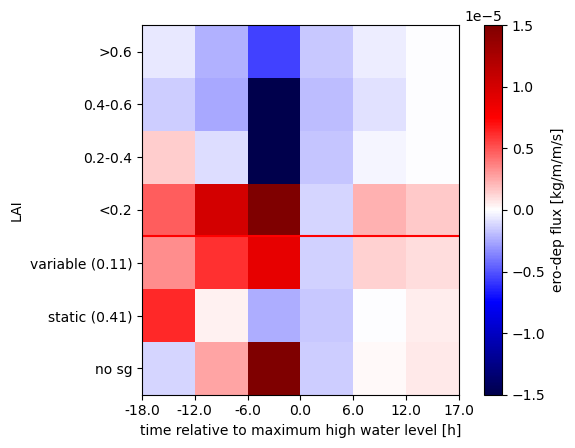

In [4]:
diff_sum_hcan = np.zeros([7,6,len(surges)]) #subsets, hcansplit, surges
s = 0
for surge in surges:
    year = str(surge[0])
    nsf = surge[1]
    #variable seagrass---------------------------------------------------------------
    ncpat = simpat+rsgname+year+'/outputs'
    files_sorted = sort_files(ncpat)[nsf-1:nsf+2]
    #find index of high water
    elev,elev_time = read_data(['elev','time'],files_sorted,node = 33665)
    nhw = np.argmax(elev)
    trel = (elev_time-elev_time[nhw])/60/60
    #splitting timeseries into subsets of ~6h surrounding hw
    nts = np.linspace(nhw-18,nhw+18,7,dtype='int')
    hcan, nsav = read_data(['ICM_hcansav','ICM_nsav'],files_sorted)
    lai = hcan*nsav*0.002
    ero,dep = read_data(['SED_eroflx','SED_depflx'],files_sorted)
    diff = ero-dep
    lai = lai[:,face_sav]
    #rearange ero-dep
    diff_tri  = np.mean(diff[:,tri],2)
    diff =diff_tri[:,face_sav]
    #split into subsets 
    #subset,t,face
    lai_subs  = [ lai[nts[i]:nts[i+1],:] for i in range(len(nts)-1)]
    print(np.nanmean(lai_subs))
    diff_subs = [diff[nts[i]:nts[i+1],:] for i in range(len(nts)-1)]
    time_subs = [trel[nts[i]:nts[i+1]]   for i in range(len(nts)-1)]
    #split by lai  (lai should be in range 0,3
    nhc = [[np.where(                      lai_subs[i]<0.2 ) for i in range(len(nts)-1)], #       lai <0.2
           [np.where((lai_subs[i]>=0.2) & (lai_subs[i]<0.4)) for i in range(len(nts)-1)], #0.2 <= lai <0.4
           [np.where((lai_subs[i]>=0.4) & (lai_subs[i]<0.6)) for i in range(len(nts)-1)], #0.4 <= lai <0.6
           [np.where((lai_subs[i]>=0.6)) for i in range(len(nts)-1)]] #0.6 <= lai
 
    
    #sum of 
    for i in range(len(nts)-1):
        for j in range(4):
            diff_sum_hcan[j+3,i,s] = np.nanmean(diff_subs[i][nhc[j][i]])
    #sum of for all var sg
    for i in range(len(nts)-1):
        diff_sum_hcan[2,i,s] = np.nanmean(diff_subs[i])
 
    #static seagrass -----------------------------------------------------------------------------------
    ncpat = simpat+ssgname+year+'/outputs'
    files_sorted = sort_files(ncpat)[nsf-1:nsf+2]

    ero,dep = read_data(['SED_eroflx','SED_depflx'],files_sorted)
    diff = ero-dep
    #sum different sed fractions, over all layers and rearange into face values
    diff_tri  = np.mean(diff[:,tri],2)
    diff =diff_tri[:,face_sav]
    #split into subsets 
    #subset,t,face
    diff_subs = [diff[nts[i]:nts[i+1],:] for i in range(len(nts)-1)]
    time_subs = [trel[nts[i]:nts[i+1]]   for i in range(len(nts)-1)]

    #sum of 
    for i in range(len(nts)-1):
        diff_sum_hcan[1,i,s] = np.nanmean(diff_subs[i])

    # no seagrass----------------------------------------------------------------------------------------
    ncpat = simpat+nsgname+year+'/outputs'
    files_sorted = sort_files(ncpat)[nsf-1:nsf+2]

    ero,dep = read_data(['SED_eroflx','SED_depflx'],files_sorted)
    diff = ero-dep
    #sum different sed fractions, over all layers and rearange into face values
    diff_tri  = np.mean(diff[:,tri],2)
    diff =diff_tri[:,face_sav]
    #split into subsets 
    #subset,t,face
    diff_subs = [diff[nts[i]:nts[i+1],:] for i in range(len(nts)-1)]
    time_subs = [trel[nts[i]:nts[i+1]]   for i in range(len(nts)-1)]

    #sum of 
    for i in range(len(nts)-1):
        diff_sum_hcan[0,i,s] = np.nanmean(diff_subs[i])
        
    #plotting--------------------------------------------------------------------------------------------
    #create labels for time axis
    tlabel = [time_subs[i][0] for i in range(len(nts)-1)]
    tlabel.append(time_subs[5][-1])
    
    #plot separately hcan
    fig, ax = plt.subplots()
    im = ax.imshow(diff_sum_hcan[:,:,s],origin='lower',cmap='seismic',vmin=-1.5e-5,vmax =1.5e-5)
    cbar = ax.figure.colorbar(im)
    cbar.ax.set_ylabel('ero-dep flux [kg/m/m/s]')
    ax.set_yticks(np.arange(7), labels=['no sg','static (0.41)','variable (0.11)','<0.2','0.2-0.4','0.4-0.6','>0.6'])
    ax.set_ylabel('LAI')
    ax.set_xticks(np.arange(len(nts))-0.5,tlabel)
    ax.set_xlabel('time relative to maximum high water level [h]')
    ax.plot(np.arange(len(nts))-0.5,np.ones(len(nts))*2.5,'r')
    plt.savefig(plotpat+'stromevent_erodep_heatmap_lai'+str(surge)+'.png')
    
    s+=1   

In [5]:
np.shape(ero)

(72, 48883)

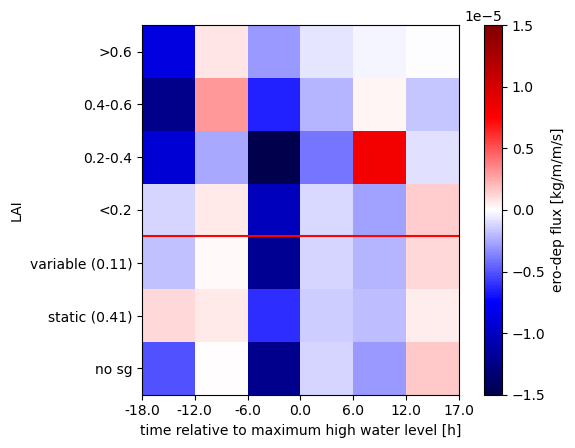

In [6]:
#plot mean for all
fig, ax = plt.subplots()
im = ax.imshow(np.nanmean(diff_sum_hcan,2),origin='lower',cmap='seismic',vmin=-1.5e-5,vmax =1.5e-5)
cbar = ax.figure.colorbar(im)
cbar.ax.set_ylabel('ero-dep flux [kg/m/m/s]')
ax.set_yticks(np.arange(7), labels=['no sg','static (0.41)','variable (0.11)','<0.2','0.2-0.4','0.4-0.6','>0.6'])
ax.set_ylabel('LAI')
ax.set_xticks(np.arange(len(nts))-0.5,tlabel)
ax.set_xlabel('time relative to maximum high water level [h]')
ax.plot(np.arange(len(nts))-0.5,np.ones(len(nts))*2.5,'r')
plt.savefig(plotpat+'stromevent_erodep_heatmap_lai_meanvarsg.png')


In [7]:
0.086*2400*0.002




0.41279999999999994

In [8]:
tlabel = [time_subs[i][0] for i in range(len(nts)-1)]
tlabel.append(time_subs[5][-1])

In [9]:
print(tlabel)


[-18.0, -12.0, -6.0, 0.0, 6.0, 12.0, 17.0]


In [10]:
[i for i in range(len(nts)-1)]

[0, 1, 2, 3, 4, 5]

In [11]:
time_subs[5][-1]

17.0